# Precipitation Seasonal Climatology

In [1]:
# Import Python modules
import os, sys
import numpy as np
import pandas as  pd
import xarray as xr
# plotting
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import AxesGrid
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
import seaborn as sns
import cmocean.cm as cmo
import cmocean
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter


from pathlib import Path
from IPython.display import Image, display
from scipy.ndimage import gaussian_filter

# Path to modules
sys.path.append('../modules')

# Import my modules
from plotter import draw_basemap, make_cmap
from ar_funcs import get_ar_days, get_topo_mask, calc_seasonal_contribution, calc_seasonal_contribution_ar_mask
import nclcmaps as nclc

### Set up paths

In [2]:
# Set up paths

path_to_data = '/home/nash/DATA/data/'                            # project data -- read only
path_to_out  = '/home/nash/DATA/repositories/AR_types/out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '/home/nash/DATA/repositories/AR_types/figs/'      # figures


In [3]:
# Set a default font for all matplotlib text (can only set this ONCE; must restart kernel to change it)
rcParams['font.family'] = 'sans-serif'   # set the default font family to 'sans-serif'
rcParams['font.sans-serif'] = 'Arial'    # set the default sans-serif font to 'Arial'


## Data

In [4]:
## Select MERRA2 or ERA5
reanalysis = 'era5'
ssn='djfmam'

# start date and end date
start_date = '1979-03-01 09:00'
end_date = '2019-02-28 09:00'

# Select lat/lon grid
lonmin = 60
lonmax = 110
latmin = 15
latmax =  50

### AR Catalog

In [5]:
# if using single bound box with elevation mask
bound_box = [20, 40, 65, 97]
trackIDs, df = get_ar_days(reanalysis, start_date, end_date, subregions=False, bbox=bound_box, elev_thres=1000.)
# fix time from 09:00 each day to 00:00
df.index = df.index.strftime("%Y-%m-%d")
df

# # if using 3 subregions and threshold
# trackIDs, df = get_ar_days(reanalysis, start_date, end_date, subregions=True, bbox=None, thresh=0.05)
# df

,ar
time,
1979-03-01,0.0
1979-03-02,0.0
1979-03-03,0.0
1979-03-04,1.0
1979-03-05,1.0
...,...
2019-02-24,0.0
2019-02-25,1.0
2019-02-26,1.0


### ERA5 reanalysis

In [6]:
### ERA5 DATA ###
def preprocess(ds):
    '''keep only selected lats and lons'''
    return ds.sel(latitude=slice(latmax, latmin), longitude=slice(lonmin, lonmax))

filepath_pattern = path_to_data + 'ERA5/prec/daily/out.era5*.nc'
era = xr.open_mfdataset(filepath_pattern, preprocess=preprocess, combine='by_coords')
print('ds size in GB {:0.2f}\n'.format(era.nbytes / 1e9))
era = era.sel(time=slice(start_date, end_date))
# fix time from 09:00 each day to 00:00
era['time'] = era.indexes['time'].normalize()

# rename lat lon prec
rename_dict_era = {'mtpr': 'prec', 
                   'latitude': 'lat',
                   'longitude': 'lon'}

era = era.rename(rename_dict_era)
era = era.assign(prec=lambda era: era['prec']*86400) # convert to mm day-1
# subset to dates

era

ds size in GB 1.70



<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 141, lon: 201, time: 14610)
Coordinates:
  * lon        (lon) float32 60.0 60.25 60.5 60.75 ... 109.25 109.5 109.75 110.0
  * lat        (lat) float32 50.0 49.75 49.5 49.25 ... 15.75 15.5 15.25 15.0
  * time       (time) datetime64[ns] 1979-03-01 1979-03-02 ... 2019-02-28
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] dask.array<chunksize=(306, 2), meta=np.ndarray>
    prec       (time, lat, lon) float64 dask.array<chunksize=(306, 141, 201), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 1.9.0 (http://mpimet.mpg.de/...
    Conventions:  CF-1.6
    history:      Wed May 27 13:22:14 2020: cdo daymean era5_hma_025dg_6hr_pr...
    frequency:    day
    CDO:          Climate Data Operators version 1.9.0rc3 (http://mpimet.mpg....

### Climatology

In [7]:
ds_lst = [era]

# # calculate seasonal contribution using AR mask
# clim_lst, frac, std_lst = calc_seasonal_contribution_ar_mask(ds_list)

# calculate seasonal contribution using AR days df
clim_lst, frac, std_lst = calc_seasonal_contribution(ds_lst, df)

## Create figure

In [8]:
# Set up projection
mapcrs = ccrs.PlateCarree()
datacrs = ccrs.PlateCarree()

# Set tick/grid locations
dx = np.arange(lonmin,lonmax+10,10)
dy = np.arange(latmin,latmax+10,10)

# get topo mask for 1000 m line
regridlats = era.lat
regridlons = era.lon
regrid_topo = get_topo_mask(regridlats, regridlons)

### Precipitation Plots

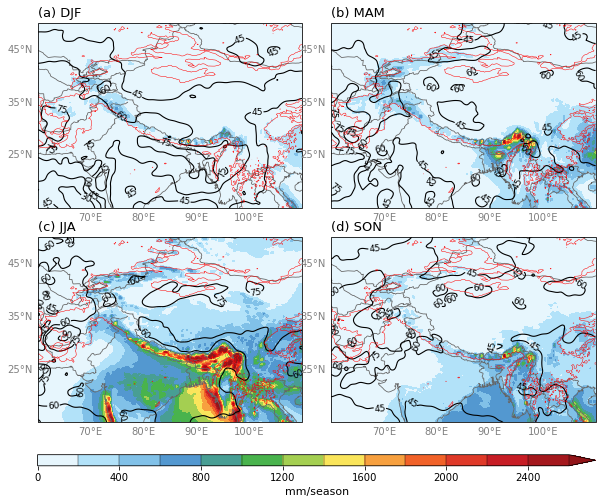

In [13]:
# Data for plotting
lons = era.lon.values
lats = era.lat.values
# Create figure
fig = plt.figure(figsize=(10,11))
nrows = 2
ncols = 2

# Set up Axes Grid
axes_class = (GeoAxes,dict(map_projection=mapcrs))
axgr = AxesGrid(fig, 111, axes_class=axes_class,
                nrows_ncols=(nrows, ncols), axes_pad = 0.40,
                cbar_location='bottom', cbar_mode='single',
                cbar_pad=0.05, cbar_size='3%',label_mode='')


# cmap="Blues"

# cmap = cmo.rain
# cmap = cmocean.tools.crop_by_percent(cmap, 20, which='min', N=None)

cmap = nclc.cmap('WhiteBlueGreenYellowRed')

cflevs = np.arange(0., 2800., 200)
# cflevs = np.array([0., 20., 40., 60., 100., 200., 400.])
plt_labels = ['(a) DJF', '(b) MAM', '(c) JJA', '(d) SON']
ssn_lst = ['DJF', 'MAM', 'JJA', 'SON']
# Loop for drawing each plot
for k, (ax, ssn) in enumerate(zip(axgr, ssn_lst)):
    ax = draw_basemap(ax, extent=[lonmin,lonmax,latmin,latmax], xticks=dx, yticks=dy)
    prec = clim_lst[0].prec.sel(season=ssn).values
    # Contour Filled
    # Average Seasonal Total
    cf = ax.contourf(lons, lats, prec, transform=datacrs,
                     levels=cflevs,
                     cmap=cmap, extend='max')
    
    
    # Contour Lines
    # Percent Contribution
    cl_data = frac[0].prec.sel(season=ssn).values
    contr = gaussian_filter(cl_data, sigma=2.0)
    clevs = np.arange(15,105,15)
    cs = ax.contour(lons, lats, contr, transform=datacrs, 
                    levels=clevs, colors='k', linewidths=1.1)
    kw_clabels = {'fontsize': 9, 'inline': True, 'inline_spacing': 8, 'fmt': '%i',
                  'rightside_up': True, 'use_clabeltext': True}
    plt.clabel(cs, **kw_clabels)
    
    # Contour Lines (terrain)
    clevs=np.array([1000])
    cs = ax.contour(regridlons, regridlats, regrid_topo.bedrock, clevs, colors='red', linewidths=0.5,
                    linestyles='solid', transform=datacrs)
    
    # Subtitles
    ax.set_title(plt_labels[k], loc='left', fontsize=13)

# Colorbar (single)
cb = fig.colorbar(cf, axgr.cbar_axes[0], orientation='horizontal', drawedges=True)
cb.set_label('mm/season', fontsize=11)
cb.ax.tick_params(labelsize=10)
    
# Save figure
filepath = path_to_figs + 'fig3_prec_clim' + '.png'
plt.savefig(filepath, dpi=400, bbox_inches='tight')

# Show
plt.show()

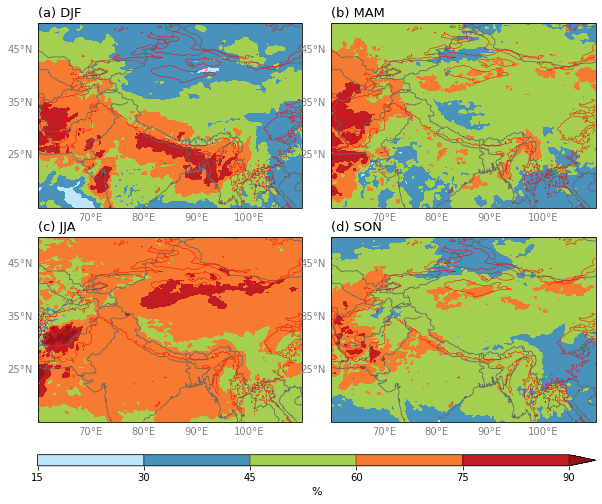

In [14]:
# Data for plotting
lons = era.lon.values
lats = era.lat.values
# Create figure
fig = plt.figure(figsize=(10,11))
nrows = 2
ncols = 2

# Set up Axes Grid
axes_class = (GeoAxes,dict(map_projection=mapcrs))
axgr = AxesGrid(fig, 111, axes_class=axes_class,
                nrows_ncols=(nrows, ncols), axes_pad = 0.40,
                cbar_location='bottom', cbar_mode='single',
                cbar_pad=0.05, cbar_size='3%',label_mode='')

cmap = nclc.cmap('WhiteBlueGreenYellowRed')

cflevs = np.arange(0., 2800., 200)
# cflevs = np.array([0., 20., 40., 60., 100., 200., 400.])
plt_labels = ['(a) DJF', '(b) MAM', '(c) JJA', '(d) SON']
ssn_lst = ['DJF', 'MAM', 'JJA', 'SON']
# Loop for drawing each plot
for k, (ax, ssn) in enumerate(zip(axgr, ssn_lst)):
    ax = draw_basemap(ax, extent=[lonmin,lonmax,latmin,latmax], xticks=dx, yticks=dy)
    cf_data = frac[0].prec.sel(season=ssn).values
    cflevs = np.arange(15,105,15)
    cmap= cmo.rain
    clipcmap = cmocean.tools.crop_by_percent(cmap, 20, which='max', N=None)
    cmap = nclc.cmap('WhiteBlueGreenYellowRed')
    # Contour Filled
    # Average Seasonal Total
    cf = ax.contourf(lons, lats, cf_data, transform=datacrs,
                     levels=cflevs,
                     cmap=cmap, extend='max')
    
    # Contour Lines (terrain)
    clevs=np.array([1000])
    cs = ax.contour(regridlons, regridlats, regrid_topo.bedrock, clevs, colors='red', linewidths=0.5,
                    linestyles='solid', transform=datacrs)
    
    # Subtitles
    ax.set_title(plt_labels[k], loc='left', fontsize=13)

# Colorbar (single)
cb = fig.colorbar(cf, axgr.cbar_axes[0], orientation='horizontal', drawedges=True)
cb.set_label('%', fontsize=11)
cb.ax.tick_params(labelsize=10)
    
# Save figure
filepath = path_to_figs + 'clim_ssn_arfrac' + '.png'
plt.savefig(filepath, dpi=400, bbox_inches='tight')

# Show
plt.show()

In [11]:
# # Data for plotting
# lons = era.lon.values
# lats = era.lat.values

# # Create figure
# fig = plt.figure(figsize=(10,11))
# nrows = 1
# ncols = 2

# # Set up Axes Grid
# axes_class = (GeoAxes,dict(map_projection=mapcrs))
# axgr = AxesGrid(fig, 111, axes_class=axes_class,
#                 nrows_ncols=(nrows, ncols), axes_pad = 0.40,
#                 cbar_location='bottom', cbar_mode='single',
#                 cbar_pad=0.05, cbar_size='3%',label_mode='')

# # cmap="Blues"

# # cmap = cmo.rain
# # cmap = cmocean.tools.crop_by_percent(cmap, 20, which='min', N=None)

# cmap = nclc.cmap('WhiteBlueGreenYellowRed')

# cflevs = np.arange(100., 1100., 100)
# # cflevs = np.array([0., 20., 40., 60., 100., 200., 400.])
# plt_labels = ['(a) DJF', '(b) MAM']
# ssn_lst = ['DJF', 'MAM']
# # Loop for drawing each plot
# for k, (ax, ssn) in enumerate(zip(axgr, ssn_lst)):
#     ax = draw_basemap(ax, extent=[lonmin,lonmax,latmin,latmax], xticks=dx, yticks=dy)
    
#     # Contour Filled
#     prec = clim_lst[0].prec.sel(season=ssn).values
#     # Average Seasonal Total
#     cf = ax.contourf(lons, lats, prec, transform=datacrs,
#                     levels=cflevs,cmap=cmap, extend='max')
    
    
#     # Contour Lines
#     # Percent Contribution
#     cl_data = frac[0].sel(season=ssn).values
#     contr = gaussian_filter(cl_data, sigma=2.5)
#     clevs = np.arange(20,105,10)
#     cs = ax.contour(lons, lats, contr, transform=datacrs,
#                     levels=clevs, colors='k', linewidths=1.1)
#     kw_clabels = {'fontsize': 9, 'inline': True, 'inline_spacing': 8, 'fmt': '%i',
#                   'rightside_up': True, 'use_clabeltext': True}
#     plt.clabel(cs, **kw_clabels)
    
#     # Contour Lines (terrain)
#     clevs=np.array([1000])
#     cs = ax.contour(regridlons, regridlats, regrid_topo.bedrock, clevs, colors='red', linewidths=0.5,
#                     linestyles='solid', transform=datacrs)
    
#     # Subtitles
#     ax.set_title(plt_labels[k], loc='left', fontsize=13)

# # Colorbar (single)
# cb = fig.colorbar(cf, axgr.cbar_axes[0], orientation='horizontal', drawedges=True)
# cb.set_label('mm/season', fontsize=11)
# cb.ax.tick_params(labelsize=10)
    
# # Save figure
# filepath = path_to_figs + 'prec_clim_contribution_djf_mam' + '.png'
# plt.savefig(filepath, dpi=400, bbox_inches='tight')

# # Show
# plt.show()